In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from sklearn.cluster import spectral_clustering
from scipy.sparse.csgraph import laplacian

Important: We need to reselect dataset to make sure each song appears at most once in a playlist (First merge genre in each playlist, then select playlists with over 20 songs); we should edit the ppt too after we finalize our dataset

In [2]:
df = pd.read_csv("playlists_filtered.csv")
display(df)

,Track URI,Track,Artist,Album,Duration,Genre,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Playlist,Pid
0,spotify:track:4pmc2AxSEq6g7hPVlJCPyP,"Jumpin', Jumpin'",Destiny's Child,The Writing's On The Wall,230200,"dance pop,girl group,pop,r&b,urban contemporary",0.771,0.685,1.0,-4.639,1.0,0.0567,0.005430,0.001570,0.0537,0.683,88.997,4.0,Throwbacks,0
1,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,Hot Shot,227600,Hiphop,0.853,0.606,0.0,-4.596,1.0,0.0713,0.056100,0.000000,0.3130,0.654,189.518,4.0,Throwbacks,0
2,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,The Cookbook,226864,Hiphop,0.904,0.813,4.0,-7.105,0.0,0.1210,0.031100,0.006970,0.0471,0.810,125.461,4.0,Throwbacks,0
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,Justified,267267,Hiphop,0.891,0.714,4.0,-6.055,0.0,0.1400,0.202000,0.000234,0.0521,0.818,201.944,4.0,Throwbacks,0
4,spotify:track:5lDriBxJd22IhOH9zTcFrV,Dirty Little Secret,The All-American Rejects,Move Along,193653,Emo,0.465,0.954,10.0,-4.251,1.0,0.0440,0.000346,0.000005,0.5730,0.458,143.850,4.0,Throwbacks,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236447,spotify:track:6ZfXA2xakAvphXOSOJ3u1W,When I Look At You,Miley Cyrus,The Time Of Our Lives,248587,Emo,0.459,0.545,6.0,-4.874,1.0,0.0282,0.142000,0.000000,0.1050,0.194,137.941,3.0,Rainy days,27426
1236448,spotify:track:7LVHVU3tWfcxj5aiPFEW4Q,Fix You,Coldplay,X & Y,295533,Pop,0.209,0.417,3.0,-8.740,1.0,0.0338,0.164000,0.001960,0.1130,0.124,138.178,4.0,Rainy days,27426
1236449,spotify:track:1VdZ0vKfR5jneCmWIUAMxK,The A Team,Ed Sheeran,+,258373,Emo,0.642,0.289,9.0,-9.918,1.0,0.0367,0.669000,0.000000,0.1800,0.407,169.992,4.0,Rainy days,27426
1236450,spotify:track:6ybViy2qrO9sIi41EgRJgx,Don't Know Why,Norah Jones,Come Away With Me,186146,"contemporary vocal jazz,jazz pop,vocal jazz",0.732,0.198,5.0,-11.775,1.0,0.0280,0.883000,0.000011,0.0659,0.618,88.174,4.0,Rainy days,27426


Here I concatenate the same songs in each playlist on our current dataset

In [3]:
def concat_genre(df):
    columns_except_genre = [col for col in df.columns if col != 'Genre']
    df_concat = df.groupby(['Track URI']).agg({
        **{col: 'first' for col in columns_except_genre},
        'Genre': lambda x: ','.join(x.astype(str)),
    }).reset_index(drop = True)
    return df_concat

In [4]:
df_new = df.groupby(['Pid'], as_index = False).apply(concat_genre).reset_index(drop = True)

df_new

We would also like to filter out a list of unique songs with features without playlist info (for song information retrieval purpose in 2.4, the recommendation section)

In [159]:
df_unique_songs = df.drop(columns = ['Playlist', 'Pid']).drop_duplicates().groupby(['Track URI'], as_index = False).apply(concat_genre).reset_index(drop = True)
df_unique_songs

,Track URI,Track,Artist,Album,Duration,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Genre
0,spotify:track:00Dj0k3r0a6HKTLanwET8L,Lights Low,2 Pistols,Lights Low,259533,0.765,0.879,5.0,-2.431,0.0,0.0569,0.0555,0.000000,0.1340,0.541,142.332,4.0,Hiphop
1,spotify:track:00FROhC5g4iJdax5US8jRr,Satisfy You,Diddy,Forever,286441,0.764,0.594,6.0,-10.050,1.0,0.1850,0.5910,0.000000,0.1450,0.695,174.522,4.0,Hiphop
2,spotify:track:00LfFm08VWeZwB0Zlm24AT,Suga Suga,Baby Bash,Tha Smokin' Nephew,239027,0.662,0.748,5.0,-3.041,0.0,0.2680,0.6880,0.000008,0.0841,0.535,164.662,4.0,RnB
3,spotify:track:00MI0oGDVJYM1qWbyUOIhH,867-5309 / Jenny,Tommy Tutone,867-5309 / Jenny,231080,0.730,0.785,2.0,-7.201,1.0,0.0456,0.0418,0.006690,0.1230,0.724,137.639,4.0,nan
4,spotify:track:00tB8c71eTcG5jV7PhuF4Q,How You Remind Me,Avril Lavigne,How You Remind Me,245360,0.612,0.698,0.0,-7.224,1.0,0.0357,0.2480,0.000003,0.1190,0.199,136.031,4.0,Emo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4842,spotify:track:7zFXmv6vqI4qOt4yGf3jYZ,Get You (feat. Kali Uchis),Daniel Caesar,Freudian,278180,0.658,0.294,4.0,-8.533,0.0,0.0321,0.4220,0.000052,0.0749,0.358,148.076,4.0,"Hiphop,RnB"
4843,spotify:track:7zP67rufQgoODWFI45jntD,Broken-Hearted Girl,Beyoncé,I AM...SASHA FIERCE - Platinum Edition,278400,0.453,0.425,5.0,-7.198,1.0,0.0325,0.4950,0.000000,0.2540,0.144,83.413,4.0,"pop,r&b"
4844,spotify:track:7zQ5nqAKKfk0gtBgV70gyq,Forever,Papa Roach,The Paramour Sessions,246333,0.575,0.591,2.0,-5.916,0.0,0.0280,0.0173,0.000000,0.1730,0.332,107.967,4.0,Emo
4845,spotify:track:7zez4ZwqfSqD6fPQgcnqwu,Phantom,Smokepurpp,Deadstar,145171,0.939,0.617,7.0,-5.933,0.0,0.2980,0.1400,0.000000,0.1120,0.680,131.949,4.0,Rap


## 1. Spectral Clustering on Unique Songs

1.1 Filter out unique songs, remove playlist id (already done)

1.2 Reduce dimensionality of dataset to 2-D/3-D and check visualization of data, see if spectral clustering is needed

1.3 Fit spectral clustering model on songs based on song features, find optimal number of clusters

1.4 Assign cluster labels, visualize results in figures and tables, rank most important features

## 2. Spectral Clustering on Playlists, using all features of songs in playlists

2.1 Assign weights to similarity between playlists (using Jaccard Similarity for playlist pairs), compute adjacency matrix

In [27]:
def playlist_similarity(playlist_1, playlist_2):
    tracks_1 = np.array(playlist_1['Track URI']).tolist()
    tracks_2 = np.array(playlist_2['Track URI']).tolist()
    num_similar_tracks = 0
    for track_1 in tracks_1:
        for track_2 in tracks_2:
            if track_1 == track_2:
                num_similar_tracks += 1
    num_total_tracks = len(tracks_1) + len(tracks_2) - num_similar_tracks
    playlist_similarity_jaccard = num_similar_tracks/num_total_tracks
    return playlist_similarity_jaccard

In [128]:
def adjacency_matrix_weighted(df):
    n = len(df["Pid"].unique())
    adjacency_matrix = np.zeros((n,n))
    unique_pid_list = df["Pid"].unique().tolist()
    count = 0
    for m, i in enumerate(unique_pid_list):
        for n, j in enumerate(unique_pid_list):
            if i !=j:
                adjacency_matrix[m,n] = playlist_similarity(df[df['Pid'] == i],df[df['Pid'] == j])
    return adjacency_matrix

2.2 Fit spectral clustering, find optimal K where all the first k eigenvalues of the Laplacian matrix are very small compared to the (k+1)th eigenvalue

2.2.1 Trial Run: Randomly select 700 training playlists and 300 testing playlists

In [164]:
# Randomly select 1000 Pids
random_integers = random.sample(range(27427), k=1000)
random_integers

[1819,
 172,
 2524,
 4816,
 4409,
 4465,
 547,
 4241,
 4221,
 2401,
 3598,
 735,
 1386,
 3069,
 318,
 1428,
 369,
 2048,
 3139,
 3037,
 463,
 2944,
 375,
 649,
 3181,
 4714,
 1770,
 4680,
 2385,
 3456,
 3631,
 4617,
 4413,
 2076,
 3676,
 2398,
 4659,
 1520,
 4454,
 3758,
 2497,
 2217,
 4192,
 1692,
 521,
 4291,
 919,
 2202,
 3718,
 2400,
 153,
 3993,
 1103,
 2836,
 3609,
 2672,
 3886,
 2455,
 2591,
 4596,
 2251,
 3184,
 2892,
 3828,
 2040,
 1339,
 627,
 2130,
 1322,
 3904,
 609,
 4195,
 1673,
 3251,
 3078,
 4798,
 4588,
 4405,
 4017,
 4502,
 4739,
 1321,
 1435,
 1775,
 631,
 4044,
 3576,
 1965,
 3917,
 902,
 4093,
 329,
 1954,
 3947,
 3805,
 3873,
 3654,
 1551,
 3278,
 1752,
 733,
 2589,
 3534,
 136,
 2109,
 4161,
 3349,
 4121,
 3237,
 3011,
 3939,
 1015,
 2805,
 61,
 4011,
 2421,
 865,
 1902,
 4282,
 2800,
 1939,
 3753,
 2051,
 2405,
 3322,
 3895,
 1337,
 2190,
 1967,
 3277,
 2678,
 3131,
 1107,
 2350,
 1663,
 4069,
 3272,
 1048,
 1448,
 1618,
 848,
 403,
 2358,
 1417,
 8,
 3420,
 131

In [144]:
# Split training and testing pid
training_pid = random_integers[:700]
testing_pid = random_integers[700:]
training_rows = df_new[df_new['Pid'].isin(training_pid)]
testing_rows = df_new[df_new['Pid'].isin(testing_pid)]

In [118]:
# Calculate Adjacency matrix on training playlists
adjacency_matrix_trial = adjacency_matrix_weighted(training_rows)

700
490000


In [119]:
adjacency_matrix_trial

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03225806, ..., 0.05797101, 0.        ,
        0.        ],
       [0.        , 0.03225806, 0.        , ..., 0.        , 0.01369863,
        0.        ],
       ...,
       [0.        , 0.05797101, 0.        , ..., 0.        , 0.20289855,
        0.        ],
       [0.        , 0.        , 0.01369863, ..., 0.20289855, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [121]:
# Find optimal K by inspecting eigenvalues of Laplacian matrix
# Calculate Laplacian matrix
laplacian_matrix = laplacian(adjacency_matrix_trial, normed=False)

# Calculate eigenvalues of the Laplacian matrix
eigenvalues, _ = np.linalg.eigh(laplacian_matrix)

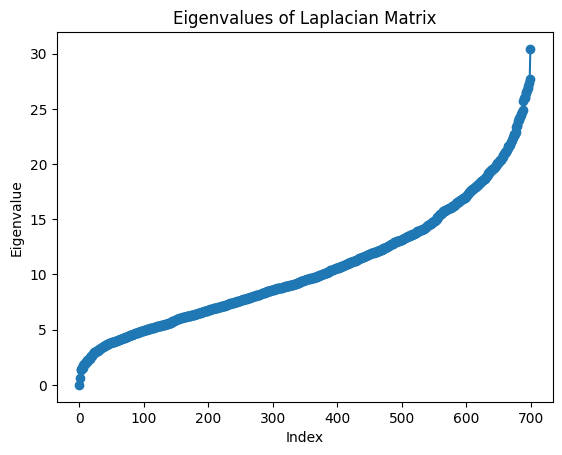

In [123]:
# Plot eigenvalues
plt.plot(eigenvalues, marker='o')
plt.title('Eigenvalues of Laplacian Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.show()

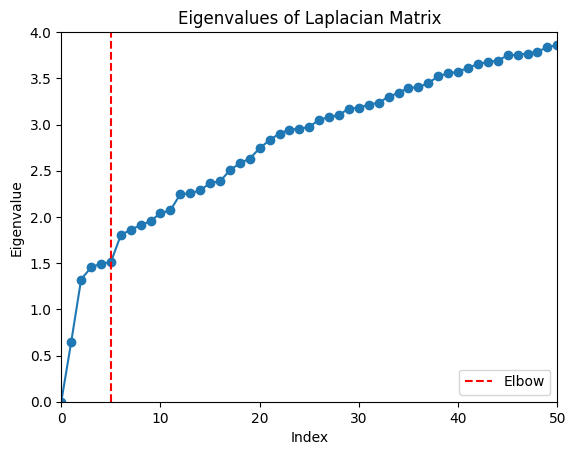

In [125]:
# Plot eigenvalues -- zoomed in to the left hand elbow
plt.plot(eigenvalues, marker='o')
plt.title('Eigenvalues of Laplacian Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.xlim(0, 50)
plt.ylim(0, 4)
elbow_index = 5
plt.axvline(x=elbow_index, color='r', linestyle='--', label='Elbow')
plt.legend()
plt.show()

* Seems k = 5 is the optimal number of clusters

In [126]:
# Fit spectral clustering model with k = 5
labels_trial = spectral_clustering(adjacency_matrix_trial, n_clusters=5, random_state = 0)

In [127]:
labels_trial

array([4, 2, 0, 3, 1, 3, 2, 4, 2, 0, 0, 0, 2, 0, 2, 2, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 2, 0, 0, 0, 2, 3, 3, 3, 0, 2, 0, 3, 4, 0, 0, 3, 0, 1, 0,
       3, 2, 0, 2, 1, 0, 3, 1, 0, 0, 3, 2, 1, 1, 3, 0, 3, 3, 2, 1, 3, 0,
       0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 4, 2, 0, 1, 2, 3,
       3, 0, 2, 1, 0, 2, 1, 0, 2, 0, 3, 1, 0, 4, 0, 3, 0, 3, 0, 0, 0, 3,
       3, 3, 3, 2, 2, 2, 2, 2, 1, 0, 3, 1, 2, 0, 0, 3, 3, 0, 0, 3, 3, 2,
       3, 3, 3, 1, 1, 0, 3, 2, 0, 3, 2, 3, 2, 3, 2, 1, 3, 0, 3, 2, 1, 1,
       2, 3, 0, 0, 3, 4, 2, 1, 2, 0, 0, 1, 0, 0, 3, 2, 0, 0, 2, 0, 0, 4,
       0, 2, 2, 1, 2, 0, 1, 1, 2, 1, 0, 3, 3, 0, 2, 2, 2, 4, 3, 3, 3, 1,
       2, 3, 2, 4, 3, 1, 0, 0, 0, 0, 3, 2, 0, 3, 3, 0, 3, 3, 2, 2, 0, 1,
       0, 0, 3, 3, 2, 0, 2, 1, 3, 0, 0, 0, 3, 0, 3, 2, 2, 0, 3, 0, 2, 0,
       3, 4, 0, 3, 2, 0, 0, 1, 3, 2, 2, 2, 2, 0, 3, 3, 3, 3, 3, 0, 1, 0,
       1, 2, 4, 3, 3, 0, 0, 3, 1, 0, 0, 2, 1, 2, 2, 0, 4, 0, 0, 2, 2, 1,
       3, 3, 0, 2, 4, 0, 3, 1, 0, 3, 0, 1, 1, 2, 3,

In [134]:
# Provide Pid and cluster label reference
labels_list = labels_trial.tolist()
training_pid_sorted = sorted(training_pid)
pid_label_reference = dict(zip(training_pid_sorted, labels_list))
pid_label_reference

{39: 4,
 48: 2,
 59: 0,
 165: 3,
 367: 1,
 406: 3,
 426: 2,
 472: 4,
 477: 2,
 650: 0,
 712: 0,
 746: 0,
 762: 2,
 764: 0,
 830: 2,
 870: 2,
 886: 1,
 926: 1,
 1002: 0,
 1058: 0,
 1101: 0,
 1232: 0,
 1234: 1,
 1270: 0,
 1271: 0,
 1283: 2,
 1313: 0,
 1351: 0,
 1373: 0,
 1416: 2,
 1514: 3,
 1516: 3,
 1604: 3,
 1610: 0,
 1616: 2,
 1631: 0,
 1640: 3,
 1748: 4,
 1786: 0,
 1813: 0,
 1923: 3,
 1948: 0,
 2047: 1,
 2062: 0,
 2079: 3,
 2083: 2,
 2222: 0,
 2317: 2,
 2326: 1,
 2389: 0,
 2416: 3,
 2430: 1,
 2460: 0,
 2471: 0,
 2567: 3,
 2580: 2,
 2645: 1,
 2722: 1,
 2800: 3,
 2810: 0,
 2870: 3,
 2879: 3,
 2881: 2,
 2902: 1,
 2974: 3,
 3010: 0,
 3037: 0,
 3068: 0,
 3100: 0,
 3102: 0,
 3117: 2,
 3185: 1,
 3275: 0,
 3301: 2,
 3381: 0,
 3433: 0,
 3485: 2,
 3521: 0,
 3562: 2,
 3579: 2,
 3612: 2,
 3621: 2,
 3657: 4,
 3665: 2,
 3678: 0,
 3689: 1,
 3691: 2,
 3713: 3,
 3730: 3,
 3757: 0,
 3759: 2,
 3799: 1,
 3808: 0,
 3811: 2,
 3827: 1,
 3898: 0,
 3947: 2,
 4014: 0,
 4019: 3,
 4061: 1,
 4066: 0,
 4069: 4,
 

In [147]:
# add cluster label to training-rows dataframe
training_rows['P_Cluster'] = training_rows['Pid'].map(pid_label_reference)

/var/folders/pq/69vgl51s55vfkk_hk7bl60x00000gn/T/ipykernel_16913/1316614441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_rows['P_Cluster'] = training_rows['Pid'].map(pid_label_reference)


In [153]:
# Get number of playlists in each cluster
def num_playlist(df):
    return len(df['Pid'].unique().tolist())

summary_table = training_rows.groupby('P_Cluster').apply(num_playlist)
print(summary_table)

P_Cluster
0    217
1     77
2    175
3    202
4     29
dtype: int64


2.2.2 (To be Continued) Actual Run: Trained on all playlists

In [ ]:
# adjacency_matrix = adjacency_matrix_weighted(df_new)
# adjacency_matrix

In [ ]:
# spectral_clustering(adjacency_matrix, n_clusters=10, random_state = 0)

2.3 Visualize clustering results in graphs

2.3.1 For Trial Run

* Spring Layout

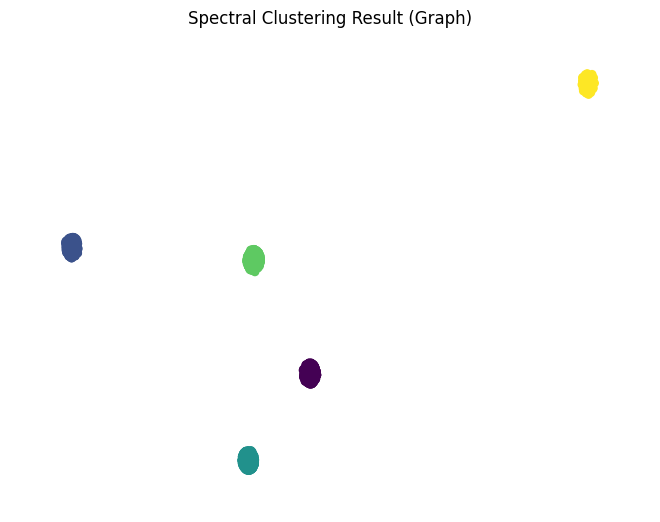

In [129]:
# Create a graph
G = nx.Graph()

# Add nodes with their respective cluster labels
for i, label in enumerate(labels_trial):
    G.add_node(i, cluster=label)

# Iterate over pairs of nodes and add edges between nodes in the same cluster
for node1, data1 in G.nodes(data=True):
    for node2, data2 in G.nodes(data=True):
        if node1 < node2 and data1['cluster'] == data2['cluster']:
            G.add_edge(node1, node2)

# Visualize the graph
pos = nx.spring_layout(G)
node_colors = [data['cluster'] for node, data in G.nodes(data=True)]
nx.draw(G, pos, with_labels=False, node_size=30, node_color=node_colors, cmap='viridis', edge_color='gray')
plt.title('Spectral Clustering Result (Graph)')
plt.show()

2.3.2 (To be continued) For actual run

2.4 Recommend songs: feed a playlist --> determine the cluster of the playlist --> randomly select another playlist from the cluster --> randomly select a song in the new playlist --> recommend the song if it is not in the original playlist, re-select another song if it is in the original playlist --> repeat the process as needed to reach the required number of songs

In [ ]:
# def retrieve_song_info(track, artist):
#     return df_unique_songs[(df_unique_songs['Track'] == track) and (df_unique_songs['Artist'] == artist)]

In [ ]:
# def add_new_playlist(playlist, name):
#     plists = np.array(playlist).tolist()
#     for plist in plists:
#         plist_row = retrieve_song_info(plist[0], plist[1])
#     playlist['Pid'] = df_new['Pid'].max() + 1
#     df_all_playlists = pd.merge(df_new, playlist, how='outer')
#     return df_all_playlists

In [ ]:
# def recommendation():

Test recommendation only, need to rewrite functions above:

In [179]:
#Randomly generate some songs
random_ints = random.sample(range(4847), k=10) #10 songs for now
new_playlist = df_unique_songs.iloc[random_ints, :].reset_index(drop = True)
new_playlist

,Track URI,Track,Artist,Album,Duration,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Genre
0,spotify:track:79XrkTOfV1AqySNjVlygpW,Energy,Drake,If You're Reading This It's Too Late,181933,0.747,0.571,11.0,-7.916,1.0,0.4780,0.380000,0.000000,0.5340,0.553,172.104,4.0,Rap
1,spotify:track:7floNISpH8VF4z4459Qo18,Look At Me!,XXXTENTACION,Look At Me!,126346,0.763,0.726,1.0,-6.405,1.0,0.2820,0.259000,0.000000,0.0976,0.349,139.059,4.0,"Rap,Trap Metal,Hiphop,Dark Trap,Underground Rap"
2,spotify:track:1vc2YF7ZvUtwr45HNpdGch,Numb,21 Savage,Issa Album,271307,0.839,0.437,5.0,-11.344,0.0,0.2850,0.043800,0.000003,0.1310,0.464,164.016,4.0,Hiphop
3,spotify:track:6qMBuoV0940COgt4cq6gwA,Low Key,$uicideBoy$,Songsthatwewontgetsuedforbutattheendofthedaywe...,122332,0.551,0.572,5.0,-4.153,1.0,0.3700,0.314000,0.000002,0.1070,0.209,169.442,3.0,Underground Rap
4,spotify:track:5qAKEQvEMo2TAjOq7qbRsK,The Truth About Heaven,Armor For Sleep,What To Do When You Are Dead,210747,0.339,0.893,2.0,-4.628,1.0,0.0786,0.000448,0.000000,0.1210,0.251,184.182,4.0,Emo
5,spotify:track:1tLw4K7LFW5TjlRAbICVTj,This Year,Lil Tracy,XOXO,120000,0.723,0.530,0.0,-9.754,0.0,0.2920,0.071800,0.000000,0.1260,0.237,160.008,4.0,Dark Trap
6,spotify:track:4K26f4Vs89qRyyn4Q8KxNo,Living For Love,Madonna,Rebel Heart,218720,0.671,0.785,1.0,-4.564,1.0,0.0797,0.043000,0.000164,0.2190,0.501,123.005,4.0,"dance pop,pop"
7,spotify:track:5fDj1YVNR04RtQNP4iYapO,No Love,Death Grips,No Love Deep Web,303693,0.547,0.884,8.0,-1.452,1.0,0.3660,0.022100,0.000001,0.0662,0.608,146.750,3.0,Hiphop
8,spotify:track:5YZRZqEkrteLmxvseHnQ2K,Live Television,Night Lovell,Concept Vague,163514,0.838,0.626,0.0,-4.214,1.0,0.0396,0.002110,0.000059,0.0221,0.108,195.988,4.0,"Trap Metal,Rap,Underground Rap"
9,spotify:track:4eSGSqP2TZvvX0kadZZttM,Doing It Wrong,Drake,Take Care,265120,0.397,0.172,6.0,-15.698,0.0,0.0445,0.841000,0.000068,0.1080,0.123,202.550,4.0,RnB


In [180]:
new_playlist['Playlist'] = 'JZFU'
new_playlist['Pid'] = df_new['Pid'].max() + 1
new_playlist

,Track URI,Track,Artist,Album,Duration,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Genre,Playlist,Pid
0,spotify:track:79XrkTOfV1AqySNjVlygpW,Energy,Drake,If You're Reading This It's Too Late,181933,0.747,0.571,11.0,-7.916,1.0,0.4780,0.380000,0.000000,0.5340,0.553,172.104,4.0,Rap,JZFU,27427
1,spotify:track:7floNISpH8VF4z4459Qo18,Look At Me!,XXXTENTACION,Look At Me!,126346,0.763,0.726,1.0,-6.405,1.0,0.2820,0.259000,0.000000,0.0976,0.349,139.059,4.0,"Rap,Trap Metal,Hiphop,Dark Trap,Underground Rap",JZFU,27427
2,spotify:track:1vc2YF7ZvUtwr45HNpdGch,Numb,21 Savage,Issa Album,271307,0.839,0.437,5.0,-11.344,0.0,0.2850,0.043800,0.000003,0.1310,0.464,164.016,4.0,Hiphop,JZFU,27427
3,spotify:track:6qMBuoV0940COgt4cq6gwA,Low Key,$uicideBoy$,Songsthatwewontgetsuedforbutattheendofthedaywe...,122332,0.551,0.572,5.0,-4.153,1.0,0.3700,0.314000,0.000002,0.1070,0.209,169.442,3.0,Underground Rap,JZFU,27427
4,spotify:track:5qAKEQvEMo2TAjOq7qbRsK,The Truth About Heaven,Armor For Sleep,What To Do When You Are Dead,210747,0.339,0.893,2.0,-4.628,1.0,0.0786,0.000448,0.000000,0.1210,0.251,184.182,4.0,Emo,JZFU,27427
5,spotify:track:1tLw4K7LFW5TjlRAbICVTj,This Year,Lil Tracy,XOXO,120000,0.723,0.530,0.0,-9.754,0.0,0.2920,0.071800,0.000000,0.1260,0.237,160.008,4.0,Dark Trap,JZFU,27427
6,spotify:track:4K26f4Vs89qRyyn4Q8KxNo,Living For Love,Madonna,Rebel Heart,218720,0.671,0.785,1.0,-4.564,1.0,0.0797,0.043000,0.000164,0.2190,0.501,123.005,4.0,"dance pop,pop",JZFU,27427
7,spotify:track:5fDj1YVNR04RtQNP4iYapO,No Love,Death Grips,No Love Deep Web,303693,0.547,0.884,8.0,-1.452,1.0,0.3660,0.022100,0.000001,0.0662,0.608,146.750,3.0,Hiphop,JZFU,27427
8,spotify:track:5YZRZqEkrteLmxvseHnQ2K,Live Television,Night Lovell,Concept Vague,163514,0.838,0.626,0.0,-4.214,1.0,0.0396,0.002110,0.000059,0.0221,0.108,195.988,4.0,"Trap Metal,Rap,Underground Rap",JZFU,27427
9,spotify:track:4eSGSqP2TZvvX0kadZZttM,Doing It Wrong,Drake,Take Care,265120,0.397,0.172,6.0,-15.698,0.0,0.0445,0.841000,0.000068,0.1080,0.123,202.550,4.0,RnB,JZFU,27427


In [187]:
training_rows_updated = pd.merge(training_rows, new_playlist, how='outer')
training_rows_updated = training_rows_updated.drop(columns = 'P_Cluster')
training_rows_updated

,Track URI,Track,Artist,Album,Duration,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Playlist,Pid,Genre
0,spotify:track:08mG3Y1vljYA6bvDt4Wqkj,Back In Black,AC/DC,Back In Black,255493,0.310,0.700,9.0,-5.678,1.0,0.0470,0.01100,0.009650,0.0828,0.763,188.386,4.0,🤘🏼,39,"australian rock,hard rock,rock"
1,spotify:track:0c1gHntWjKD7QShC8s99sq,I Don't Want to Miss a Thing - From the Touchs...,Aerosmith,I Don't Want To Miss A Thing,299760,0.390,0.649,2.0,-5.163,1.0,0.0345,0.17200,0.000000,0.2160,0.144,121.160,4.0,🤘🏼,39,"album rock,classic rock,hard rock,rock"
2,spotify:track:1AhDOtG9vPSOmsWgNW0BEY,Bohemian Rhapsody - Remastered 2011,Queen,A Night At The Opera,354320,0.414,0.404,0.0,-9.928,0.0,0.0499,0.27100,0.000000,0.3000,0.224,142.210,4.0,🤘🏼,39,Emo
3,spotify:track:1bdXMstfxFWYSkEFTnJMoN,Enter Sandman,Metallica,Metallica,331266,0.577,0.828,6.0,-8.691,0.0,0.0298,0.00213,0.011400,0.0581,0.604,123.257,4.0,🤘🏼,39,"hard rock,metal,old school thrash,rock,thrash ..."
4,spotify:track:1znPMY3zq78mVuTAmOA9O7,Nothing Else Matters,Metallica,Metallica,388266,0.553,0.362,4.0,-11.218,0.0,0.0263,0.04580,0.000006,0.0750,0.158,142.352,3.0,🤘🏼,39,"hard rock,metal,old school thrash,rock,thrash ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20909,spotify:track:1tLw4K7LFW5TjlRAbICVTj,This Year,Lil Tracy,XOXO,120000,0.723,0.530,0.0,-9.754,0.0,0.2920,0.07180,0.000000,0.1260,0.237,160.008,4.0,JZFU,27427,Dark Trap
20910,spotify:track:4K26f4Vs89qRyyn4Q8KxNo,Living For Love,Madonna,Rebel Heart,218720,0.671,0.785,1.0,-4.564,1.0,0.0797,0.04300,0.000164,0.2190,0.501,123.005,4.0,JZFU,27427,"dance pop,pop"
20911,spotify:track:5fDj1YVNR04RtQNP4iYapO,No Love,Death Grips,No Love Deep Web,303693,0.547,0.884,8.0,-1.452,1.0,0.3660,0.02210,0.000001,0.0662,0.608,146.750,3.0,JZFU,27427,Hiphop
20912,spotify:track:5YZRZqEkrteLmxvseHnQ2K,Live Television,Night Lovell,Concept Vague,163514,0.838,0.626,0.0,-4.214,1.0,0.0396,0.00211,0.000059,0.0221,0.108,195.988,4.0,JZFU,27427,"Trap Metal,Rap,Underground Rap"


In [188]:
adjacency_matrix_trial_updated = adjacency_matrix_weighted(training_rows_updated)

In [189]:
adjacency_matrix_trial_updated

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03225806, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03225806, 0.        , ..., 0.01369863, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.01369863, ..., 0.        , 0.        ,
        0.01923077],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01923077, 0.        ,
        0.        ]])

In [190]:
# Find optimal K by inspecting eigenvalues of Laplacian matrix
# Calculate Laplacian matrix
laplacian_matrix_updated = laplacian(adjacency_matrix_trial_updated, normed=False)

# Calculate eigenvalues of the Laplacian matrix
eigenvalues_updated, _ = np.linalg.eigh(laplacian_matrix_updated)

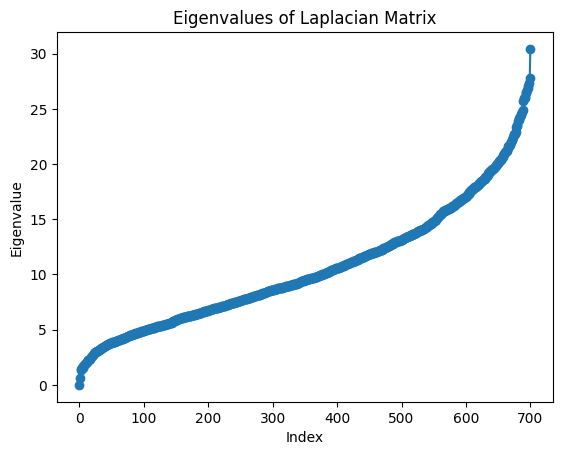

In [191]:
# Plot eigenvalues
plt.plot(eigenvalues_updated, marker='o')
plt.title('Eigenvalues of Laplacian Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.show()

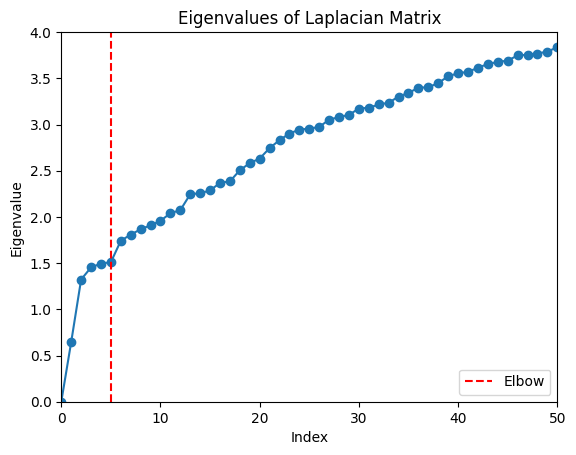

In [192]:
# Plot eigenvalues -- zoomed in to the left hand elbow
plt.plot(eigenvalues_updated, marker='o')
plt.title('Eigenvalues of Laplacian Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.xlim(0, 50)
plt.ylim(0, 4)
elbow_index = 5
plt.axvline(x=elbow_index, color='r', linestyle='--', label='Elbow')
plt.legend()
plt.show()

In [193]:
# Fit spectral clustering model with k = 5
labels_trial_updated = spectral_clustering(adjacency_matrix_trial_updated, n_clusters=5, random_state = 0)

In [194]:
labels_trial_updated

array([2, 1, 0, 4, 3, 4, 1, 2, 1, 0, 0, 0, 1, 0, 1, 1, 3, 3, 0, 0, 0, 0,
       3, 0, 0, 1, 0, 0, 0, 1, 4, 4, 4, 0, 1, 0, 4, 2, 4, 0, 4, 0, 3, 0,
       4, 1, 0, 1, 3, 0, 4, 3, 4, 0, 4, 1, 3, 3, 4, 0, 4, 4, 1, 3, 4, 0,
       0, 0, 0, 0, 1, 3, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 1, 0, 3, 1, 4,
       4, 0, 1, 3, 0, 1, 3, 0, 1, 0, 4, 3, 0, 2, 0, 4, 0, 4, 0, 0, 0, 4,
       4, 4, 4, 1, 1, 1, 1, 1, 3, 0, 4, 3, 1, 0, 0, 4, 4, 0, 0, 4, 4, 1,
       4, 4, 4, 3, 3, 0, 4, 1, 0, 4, 1, 4, 1, 4, 1, 3, 4, 0, 4, 1, 3, 3,
       1, 4, 0, 0, 4, 2, 1, 3, 1, 0, 0, 3, 0, 0, 4, 1, 0, 0, 1, 0, 0, 2,
       0, 1, 1, 3, 1, 0, 3, 3, 1, 3, 0, 4, 4, 0, 1, 1, 1, 2, 4, 4, 4, 3,
       1, 4, 1, 2, 4, 3, 0, 0, 0, 0, 4, 1, 0, 4, 4, 0, 4, 4, 1, 1, 0, 3,
       0, 0, 4, 4, 1, 0, 1, 3, 4, 0, 0, 0, 4, 0, 4, 1, 1, 0, 4, 0, 1, 0,
       4, 2, 0, 4, 1, 0, 0, 3, 4, 1, 1, 1, 1, 0, 4, 4, 4, 4, 4, 0, 3, 4,
       3, 1, 2, 4, 4, 0, 0, 4, 3, 0, 0, 1, 3, 1, 1, 0, 2, 0, 0, 1, 1, 3,
       4, 4, 0, 1, 2, 0, 4, 3, 0, 4, 0, 3, 3, 1, 4,

In [195]:
# Provide Pid and cluster label reference
labels_list_updated = labels_trial_updated.tolist()
training_pid_sorted_updated = sorted(training_rows_updated["Pid"].unique().tolist())
pid_label_reference_updated = dict(zip(training_pid_sorted_updated, labels_list_updated))
pid_label_reference_updated

{39: 2,
 48: 1,
 59: 0,
 165: 4,
 367: 3,
 406: 4,
 426: 1,
 472: 2,
 477: 1,
 650: 0,
 712: 0,
 746: 0,
 762: 1,
 764: 0,
 830: 1,
 870: 1,
 886: 3,
 926: 3,
 1002: 0,
 1058: 0,
 1101: 0,
 1232: 0,
 1234: 3,
 1270: 0,
 1271: 0,
 1283: 1,
 1313: 0,
 1351: 0,
 1373: 0,
 1416: 1,
 1514: 4,
 1516: 4,
 1604: 4,
 1610: 0,
 1616: 1,
 1631: 0,
 1640: 4,
 1748: 2,
 1786: 4,
 1813: 0,
 1923: 4,
 1948: 0,
 2047: 3,
 2062: 0,
 2079: 4,
 2083: 1,
 2222: 0,
 2317: 1,
 2326: 3,
 2389: 0,
 2416: 4,
 2430: 3,
 2460: 4,
 2471: 0,
 2567: 4,
 2580: 1,
 2645: 3,
 2722: 3,
 2800: 4,
 2810: 0,
 2870: 4,
 2879: 4,
 2881: 1,
 2902: 3,
 2974: 4,
 3010: 0,
 3037: 0,
 3068: 0,
 3100: 0,
 3102: 0,
 3117: 1,
 3185: 3,
 3275: 0,
 3301: 1,
 3381: 0,
 3433: 0,
 3485: 1,
 3521: 0,
 3562: 1,
 3579: 1,
 3612: 1,
 3621: 1,
 3657: 2,
 3665: 1,
 3678: 0,
 3689: 3,
 3691: 1,
 3713: 4,
 3730: 4,
 3757: 0,
 3759: 1,
 3799: 3,
 3808: 0,
 3811: 1,
 3827: 3,
 3898: 0,
 3947: 1,
 4014: 0,
 4019: 4,
 4061: 3,
 4066: 0,
 4069: 2,
 

In [196]:
# add cluster label to training-rows dataframe
training_rows_updated['P_Cluster'] = training_rows_updated['Pid'].map(pid_label_reference_updated)

In [197]:
# Get number of playlists in each cluster
summary_table_updated = training_rows_updated.groupby('P_Cluster').apply(num_playlist)
print(summary_table_updated)

P_Cluster
0    210
1    175
2     29
3     77
4    210
dtype: int64


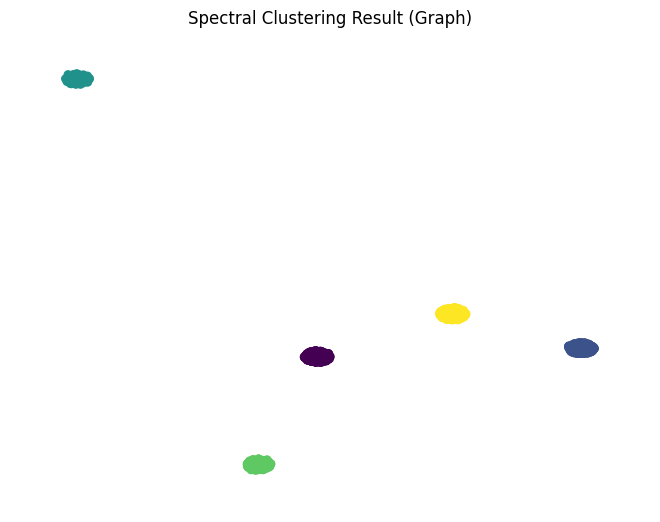

In [198]:
# Create a graph
G = nx.Graph()

# Add nodes with their respective cluster labels
for i, label in enumerate(labels_trial_updated):
    G.add_node(i, cluster=label)

# Iterate over pairs of nodes and add edges between nodes in the same cluster
for node1, data1 in G.nodes(data=True):
    for node2, data2 in G.nodes(data=True):
        if node1 < node2 and data1['cluster'] == data2['cluster']:
            G.add_edge(node1, node2)

# Visualize the graph
pos = nx.spring_layout(G)
node_colors = [data['cluster'] for node, data in G.nodes(data=True)]
nx.draw(G, pos, with_labels=False, node_size=30, node_color=node_colors, cmap='viridis', edge_color='gray')
plt.title('Spectral Clustering Result (Graph)')
plt.show()

In [ ]:
* Recommendation start below

In [199]:
training_rows_updated[training_rows_updated['Pid']==27427]

,Track URI,Track,Artist,Album,Duration,Danceability,Energy,Key,Loudness,Mode,...,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Playlist,Pid,Genre,P_Cluster
20904,spotify:track:79XrkTOfV1AqySNjVlygpW,Energy,Drake,If You're Reading This It's Too Late,181933,0.747,0.571,11.0,-7.916,1.0,...,0.380000,0.000000,0.5340,0.553,172.104,4.0,JZFU,27427,Rap,4
20905,spotify:track:7floNISpH8VF4z4459Qo18,Look At Me!,XXXTENTACION,Look At Me!,126346,0.763,0.726,1.0,-6.405,1.0,...,0.259000,0.000000,0.0976,0.349,139.059,4.0,JZFU,27427,"Rap,Trap Metal,Hiphop,Dark Trap,Underground Rap",4
20906,spotify:track:1vc2YF7ZvUtwr45HNpdGch,Numb,21 Savage,Issa Album,271307,0.839,0.437,5.0,-11.344,0.0,...,0.043800,0.000003,0.1310,0.464,164.016,4.0,JZFU,27427,Hiphop,4
20907,spotify:track:6qMBuoV0940COgt4cq6gwA,Low Key,$uicideBoy$,Songsthatwewontgetsuedforbutattheendofthedaywe...,122332,0.551,0.572,5.0,-4.153,1.0,...,0.314000,0.000002,0.1070,0.209,169.442,3.0,JZFU,27427,Underground Rap,4
20908,spotify:track:5qAKEQvEMo2TAjOq7qbRsK,The Truth About Heaven,Armor For Sleep,What To Do When You Are Dead,210747,0.339,0.893,2.0,-4.628,1.0,...,0.000448,0.000000,0.1210,0.251,184.182,4.0,JZFU,27427,Emo,4
20909,spotify:track:1tLw4K7LFW5TjlRAbICVTj,This Year,Lil Tracy,XOXO,120000,0.723,0.530,0.0,-9.754,0.0,...,0.071800,0.000000,0.1260,0.237,160.008,4.0,JZFU,27427,Dark Trap,4
20910,spotify:track:4K26f4Vs89qRyyn4Q8KxNo,Living For Love,Madonna,Rebel Heart,218720,0.671,0.785,1.0,-4.564,1.0,...,0.043000,0.000164,0.2190,0.501,123.005,4.0,JZFU,27427,"dance pop,pop",4
20911,spotify:track:5fDj1YVNR04RtQNP4iYapO,No Love,Death Grips,No Love Deep Web,303693,0.547,0.884,8.0,-1.452,1.0,...,0.022100,0.000001,0.0662,0.608,146.750,3.0,JZFU,27427,Hiphop,4
20912,spotify:track:5YZRZqEkrteLmxvseHnQ2K,Live Television,Night Lovell,Concept Vague,163514,0.838,0.626,0.0,-4.214,1.0,...,0.002110,0.000059,0.0221,0.108,195.988,4.0,JZFU,27427,"Trap Metal,Rap,Underground Rap",4
20913,spotify:track:4eSGSqP2TZvvX0kadZZttM,Doing It Wrong,Drake,Take Care,265120,0.397,0.172,6.0,-15.698,0.0,...,0.841000,0.000068,0.1080,0.123,202.550,4.0,JZFU,27427,RnB,4


In [200]:
pool_of_recommendation = training_rows_updated[training_rows_updated['P_Cluster'] == 4].groupby('Pid').apply(lambda x:x)
pool_of_recommendation

Track URI  \
Pid                                                 
165   84     spotify:track:0utlOiJy2weVl9WTkcEWHy   
      85     spotify:track:1BSA5I386L2IAmFQURYjIz   
      86     spotify:track:1LxKKYsJNPeBdOwdudsJzv   
      87     spotify:track:1f5cbQtDrykjarZVrShaDI   
      88     spotify:track:1wHZx0LgzFHyeIZkUydNXq   
...                                           ...   
27427 20909  spotify:track:1tLw4K7LFW5TjlRAbICVTj   
      20910  spotify:track:4K26f4Vs89qRyyn4Q8KxNo   
      20911  spotify:track:5fDj1YVNR04RtQNP4iYapO   
      20912  spotify:track:5YZRZqEkrteLmxvseHnQ2K   
      20913  spotify:track:4eSGSqP2TZvvX0kadZZttM   

                                                     Track  \
Pid                                                          
165   84                                         Neighbors   
      85     Guwop (feat. Quavo, Offset and Young Scooter)   
      86                                    Down In the DM   
      87                      Drowning (feat. Kodak Black)   
      88                                          Antidote   
...                                                    ...   
27427 20909                                      This Year   
      20910                                Living For Love   
      20911                                        No Love   
      20912                                Live Television   
      20913                                 Doing It Wrong   

                             Artist              Album  Duration  \
Pid                                                                
165   84                    J. Cole   4 Your Eyez Only    216520   
      85                 Young Thug            JEFFERY    315973   
      86                   Yo Gotti  The Art of Hustle    182733   
      87     A Boogie Wit da Hoodie  The Bigger Artist    209269   
      88               Travis Scott              Rodeo    262693   
...                             ...                ...       ...   
27427 20909               Lil Tracy               XOXO    120000   
      20910                 Madonna        Rebel Heart    218720   
      20911             Death Grips   No Love Deep Web    303693   
      20912            Night Lovell      Concept Vague    163514   
      20913                   Drake          Take Care    265120   

             Danceability  Energy  Key  Loudness  Mode  ...  Acousticness  \
Pid                                                     ...                 
165   84            0.898   0.283  6.0   -12.335   0.0  ...       0.31900   
      85            0.883   0.616  0.0    -7.218   0.0  ...       0.01400   
      86            0.776   0.662  1.0    -7.016   0.0  ...       0.00157   
      87            0.839   0.810  5.0    -5.274   0.0  ...       0.50100   
      88            0.713   0.526  1.0    -5.046   1.0  ...       0.00767   
...                   ...     ...  ...       ...   ...  ...           ...   
27427 20909         0.723   0.530  0.0    -9.754   0.0  ...       0.07180   
      20910         0.671   0.785  1.0    -4.564   1.0  ...       0.04300   
      20911         0.547   0.884  8.0    -1.452   1.0  ...       0.02210   
      20912         0.838   0.626  0.0    -4.214   1.0  ...       0.00211   
      20913         0.397   0.172  6.0   -15.698   0.0  ...       0.84100   

             Instrumentalness  Liveness  Valence    Tempo  Time Signature  \
Pid                                                                         
165   84             0.000383    0.1100    0.469  138.970             4.0   
      85             0.000001    0.0967    0.482  141.969             4.0   
      86             0.000021    0.0887    0.324  152.927             4.0   
      87             0.000000    0.1170    0.814  129.014             4.0   
      88             0.000148    0.1240    0.131  131.050             4.0   
...                       ...       ...      ...      ...             ...   
27427 20909          0.000000    0.1260 

In [208]:
Pid_pool = pool_of_recommendation['Pid'].unique().tolist()
random_pid = random.sample(Pid_pool, k=1)
random_pid = random_pid[0]
random_pid

26029

In [211]:
songs_in_random_pit = pool_of_recommendation[pool_of_recommendation['Pid'] == random_pid]
songs_in_random_pit

Track URI  \
Pid                                                 
26029 19851  spotify:track:05KOgYg8PGeJyyWBPi5ja8   
      19852  spotify:track:07pJdL0L9XDGW0HBj0rIS2   
      19853  spotify:track:0BU7nIcCZxYSE0hYcc5oZz   
      19854  spotify:track:0Fv5N0cHBsl4bzCbollCAS   
      19855  spotify:track:0Kojfmpnf0A2yC1zyv39Zx   
...                                           ...   
      19928  spotify:track:7EoSDrwBPUBeBEORrpvgko   
      19929  spotify:track:7KXjTSCq5nL1LoYtL7XAwS   
      19930  spotify:track:7cGFbx7MP0H23iHZTZpqMM   
      19931  spotify:track:7fRfIvHPH6bHdMDjPFwTMh   
      19932  spotify:track:7hDc8b7IXETo14hHIHdnhd   

                                     Track          Artist  \
Pid                                                          
26029 19851                     Free Smoke           Drake   
      19852  Skateboard P (feat. Big Sean)       MadeinTYO   
      19853                 Too Many Years     Kodak Black   
      19854                          Moves        Big Sean   
      19855                   Buried Alive           Logic   
...                                    ...             ...   
      19928                          Water        Ugly God   
      19929                        HUMBLE.  Kendrick Lamar   
      19930                      Everybody           Logic   
      19931                     Hallelujah           Logic   
      19932                   Passionfruit           Drake   

                                     Album  Duration  Danceability  Energy  \
Pid                                                                          
26029 19851                      More Life    218674         0.736   0.491   
      19852  Skateboard P (feat. Big Sean)    242307         0.831   0.470   
      19853                    Lil Big Pac    196336         0.665   0.706   
      19854                     I Decided.    142907         0.812   0.522   
      19855                 Under Pressure    337747         0.755   0.830   
...                                    ...       ...           ...     ...   
      19928                 The Booty Tape    138936         0.816   0.245   
      19929                          DAMN.    177000         0.908   0.621   
      19930                      Everybody    162347         0.885   0.940   
      19931                      Everybody    448733         0.674   0.596   
      19932                      More Life    298941         0.809   0.463   

              Key  Loudness  Mode  ...  Acousticness  Instrumentalness  \
Pid                                ...                                   
26029 19851  10.0    -6.892   0.0  ...      0.068100          0.000000   
      19852   1.0    -7.480   0.0  ...      0.037100          0.000000   
      19853   8.0    -6.859   0.0  ...      0.023700          0.000000   
      19854   2.0    -5.287   1.0  ...      0.043300          0.000000   
      19855   3.0    -6.494   0.0  ...      0.091600          0.000038   
...           ...       ...   ...  ...           ...               ...   
      19928   0.0   -15.617   0.0  ...      0.616000          0.000813   
      19929   1.0    -6.638   0.0  ...      0.000282          0.000054   
      19930   1.0    -5.908   1.0  ...      0.161000          0.000000   
      19931  11.0    -8.348   0.0  ...      0.495000          0.000003   
      19932  11.0   -11.377   1.0  ...      0.256000          0.085000   

             Liveness  Valence    Tempo  Time Signature  Playlist    Pid  \
Pid                                                                        
26029 19851    0.5710    0.203  141.979             4.0      2017  26029   
      19852    0.1440    0.339  150.948             4.0      2017  26029   
      19853    0.1120    0.632  147.067             4.0      2017  26029   
      19854    0.1540    0.380  151.048             4.0      2017  26029   
      19855    0.2980    0.513  139.900             4.0      2017  26029   
...               ...      ...   

In [212]:
#Songs to be recommended
random_sample = songs_in_random_pit.sample(n=10, random_state=0)
random_sample

Track URI  \
Pid                                                 
26029 19878  spotify:track:2XaInsPPUkZRkY4uFJ3AHK   
      19853  spotify:track:0BU7nIcCZxYSE0hYcc5oZz   
      19913  spotify:track:6IlQTriFgUeEbVx3Y10sia   
      19894  spotify:track:3vWxQ6wOfMr8zH1u7pVFI6   
      19859  spotify:track:0v9Wz8o0BT8DU38R4ddjeH   
      19893  spotify:track:3pndPhlQWjuSoXhcIIdBjv   
      19891  spotify:track:3muBQDekYAg7jm6hDu6R0Z   
      19864  spotify:track:1MksGqIztTT6M9R1ErKVs8   
      19930  spotify:track:7cGFbx7MP0H23iHZTZpqMM   
      19904  spotify:track:55OdqrG8WLmsYyY1jijD9b   

                                               Track             Artist  \
Pid                                                                       
26029 19878                  Met Gala (feat. Offset)         Gucci Mane   
      19853                           Too Many Years        Kodak Black   
      19913                         Driving Ms Daisy              Logic   
      19894                                Bust Down       Trippie Redd   
      19859  No Problem (feat. Lil Wayne & 2 Chainz)  Chance The Rapper   
      19893                           What They Want               Russ   
      19891                            First Day Out       Tee Grizzley   
      19864                                No Favors           Big Sean   
      19930                                Everybody              Logic   
      19904                              Wyclef Jean         Young Thug   

                              Album  Duration  Danceability  Energy   Key  \
Pid                                                                         
26029 19878              Droptopwop    209143         0.817   0.587   2.0   
      19853             Lil Big Pac    196336         0.665   0.706   8.0   
      19913          Under Pressure    240587         0.657   0.822   9.0   
      19894  A Love Letter To You 2    245229         0.722   0.821   2.0   
      19859           Coloring Book    304607         0.652   0.795  11.0   
      19893   There's Really A Wolf    165853         0.710   0.404   1.0   
      19891               My Moment    254694         0.587   0.711   1.0   
      19864              I Decided.    325840         0.482   0.781  11.0   
      19930               Everybody    162347         0.885   0.940   1.0   
      19904                 JEFFERY    236293         0.863   0.576   5.0   

             Loudness  Mode  ...  Acousticness  Instrumentalness  Liveness  \
Pid                          ...                                             
26029 19878    -6.502   1.0  ...        0.0520          0.001650    0.1850   
      19853    -6.859   0.0  ...        0.0237          0.000000    0.1120   
      19913    -4.612   0.0  ...        0.3700          0.000002    0.1040   
      19894    -4.167   1.0  ...        0.3370          0.000021    0.1500   
      19859    -5.192   0.0  ...        0.1560          0.000000    0.1230   
      19893   -10.040   0.0  ...        0.4840          0.000000    0.0953   
      19891    -6.330   1.0  ...        0.1710          0.000000    0.1250   
      19864    -5.334   1.0  ...        0.6290          0.000003    0.4130   
      19930    -5.908   1.0  ...        0.1610          0.000000    0.0675   
      19904    -5.687   0.0  ...        0.1240          0.000000    0.1430   

             Valence    Tempo  Time Signature  Playlist    Pid  \
Pid                                                              
26029 19878    0.352  140.062             4.0      2017  26029   
      19853    0.632  147.067             4.0      2017  26029   
      19913    0.536  160.049             4.0      2017  26029   
      19894    0.659   73.015             4.0      2017  26029   
      19859    0.788  135.018             4.0      2017  26029   
      19893    0.398  139.553             4.0      2017  26029   
      19891    0.381  196.016             4.0      2017  26029   
      19864    0.336   57.967             5.0 

In [213]:
new_playlist

,Track URI,Track,Artist,Album,Duration,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Genre,Playlist,Pid
0,spotify:track:79XrkTOfV1AqySNjVlygpW,Energy,Drake,If You're Reading This It's Too Late,181933,0.747,0.571,11.0,-7.916,1.0,0.4780,0.380000,0.000000,0.5340,0.553,172.104,4.0,Rap,JZFU,27427
1,spotify:track:7floNISpH8VF4z4459Qo18,Look At Me!,XXXTENTACION,Look At Me!,126346,0.763,0.726,1.0,-6.405,1.0,0.2820,0.259000,0.000000,0.0976,0.349,139.059,4.0,"Rap,Trap Metal,Hiphop,Dark Trap,Underground Rap",JZFU,27427
2,spotify:track:1vc2YF7ZvUtwr45HNpdGch,Numb,21 Savage,Issa Album,271307,0.839,0.437,5.0,-11.344,0.0,0.2850,0.043800,0.000003,0.1310,0.464,164.016,4.0,Hiphop,JZFU,27427
3,spotify:track:6qMBuoV0940COgt4cq6gwA,Low Key,$uicideBoy$,Songsthatwewontgetsuedforbutattheendofthedaywe...,122332,0.551,0.572,5.0,-4.153,1.0,0.3700,0.314000,0.000002,0.1070,0.209,169.442,3.0,Underground Rap,JZFU,27427
4,spotify:track:5qAKEQvEMo2TAjOq7qbRsK,The Truth About Heaven,Armor For Sleep,What To Do When You Are Dead,210747,0.339,0.893,2.0,-4.628,1.0,0.0786,0.000448,0.000000,0.1210,0.251,184.182,4.0,Emo,JZFU,27427
5,spotify:track:1tLw4K7LFW5TjlRAbICVTj,This Year,Lil Tracy,XOXO,120000,0.723,0.530,0.0,-9.754,0.0,0.2920,0.071800,0.000000,0.1260,0.237,160.008,4.0,Dark Trap,JZFU,27427
6,spotify:track:4K26f4Vs89qRyyn4Q8KxNo,Living For Love,Madonna,Rebel Heart,218720,0.671,0.785,1.0,-4.564,1.0,0.0797,0.043000,0.000164,0.2190,0.501,123.005,4.0,"dance pop,pop",JZFU,27427
7,spotify:track:5fDj1YVNR04RtQNP4iYapO,No Love,Death Grips,No Love Deep Web,303693,0.547,0.884,8.0,-1.452,1.0,0.3660,0.022100,0.000001,0.0662,0.608,146.750,3.0,Hiphop,JZFU,27427
8,spotify:track:5YZRZqEkrteLmxvseHnQ2K,Live Television,Night Lovell,Concept Vague,163514,0.838,0.626,0.0,-4.214,1.0,0.0396,0.002110,0.000059,0.0221,0.108,195.988,4.0,"Trap Metal,Rap,Underground Rap",JZFU,27427
9,spotify:track:4eSGSqP2TZvvX0kadZZttM,Doing It Wrong,Drake,Take Care,265120,0.397,0.172,6.0,-15.698,0.0,0.0445,0.841000,0.000068,0.1080,0.123,202.550,4.0,RnB,JZFU,27427
